In [7]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
from skimage import feature
from tqdm import tqdm

In [8]:
class LocalBinaryPatterns:
	def __init__(self, numPoints, radius):
		# store the number of points and radius
		self.numPoints = numPoints
		self.radius = radius
	def describe(self, image, eps=1e-7):
		# compute the Local Binary Pattern representation
		# of the image, and then use the LBP representation
		# to build the histogram of patterns
		lbp = feature.local_binary_pattern(image, self.numPoints,
			self.radius, method="uniform")
		(hist, _) = np.histogram(lbp.ravel(),
			bins=np.arange(0, self.numPoints + 3),
			range=(0, self.numPoints + 2))
		# normalize the histogram
		hist = hist.astype("float")
		hist = hist / (hist.sum() + eps)
		# return the histogram of Local Binary Patterns
		return hist

In [9]:
path = '../dataset' ## TODO: Change this to the path of your dataset. (The code will look through every subfolder for images)

images = []
for x, y, z in os.walk(path):
    for name in tqdm(z):
        images.append(os.path.join(x, name).replace('\\','/')) 



0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 629/629 [00:00<00:00, 125839.12it/s]
0it [00:00, ?it/s]
100%|██████████| 1114/1114 [00:00<00:00, 159089.37it/s]


In [10]:
lbp_df = pd.DataFrame()


# the parameters of the LBP algo
# higher = more time required
sample_points = 16
radius = 4

# this code takes a while
for i in tqdm(images):
    img = cv2.imread(i)
    lbp = LocalBinaryPatterns(sample_points, radius).describe(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    row = dict(zip(range(0, len(lbp)), lbp))
    row['ageRange'] = i.split('/')[3] ## TODO: change 3 to the index in the path where the age range is located
    ## for example, mine was ../dataset/female/age_10_14/imagename => split by / => index 3
    lbp_df = lbp_df.append(row, ignore_index=True)


100%|██████████| 36299/36299 [11:36<00:00, 52.13it/s]


In [11]:
# number of null values in our df. Should always be 0
lbp_df[2].isna().sum()

0

In [12]:
corrM = lbp_df.corr()
print(corrM)

          0         1         2         3         4         5         6   \
0   1.000000  0.839920  0.194847 -0.241171 -0.481924 -0.641390 -0.702232   
1   0.839920  1.000000  0.283541 -0.251165 -0.546574 -0.712553 -0.773238   
2   0.194847  0.283541  1.000000  0.608972  0.164237 -0.169252 -0.305062   
3  -0.241171 -0.251165  0.608972  1.000000  0.652527  0.296901  0.125215   
4  -0.481924 -0.546574  0.164237  0.652527  1.000000  0.727826  0.536645   
5  -0.641390 -0.712553 -0.169252  0.296901  0.727826  1.000000  0.831675   
6  -0.702232 -0.773238 -0.305062  0.125215  0.536645  0.831675  1.000000   
7  -0.802324 -0.815550 -0.382006  0.025795  0.358564  0.591807  0.792409   
8  -0.806808 -0.763310 -0.342003  0.023474  0.280885  0.449906  0.613472   
9  -0.838463 -0.806362 -0.259230  0.151666  0.340191  0.495613  0.573383   
10 -0.561276 -0.572074 -0.026521  0.295059  0.383273  0.428561  0.402449   
11 -0.306096 -0.316838  0.131106  0.318578  0.274692  0.239332  0.112828   
12 -0.201880

In [13]:
# the age groups we decide we call 'young'
young = ['age_10_14',
'age_15_19',
'age_20_24',
'age_25_29',
'age_30_34',
'age_35_39',
'age_40_44', 'age_45_49']

# in this column, true means young, false means old
lbp_df['age_new'] = lbp_df['ageRange'].isin(young)

In [14]:
lbp_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,ageRange,age_new
0,0.035583,0.044861,0.028137,0.021729,0.020874,0.022949,0.038879,0.072021,0.107544,0.079285,0.036865,0.023804,0.020020,0.019226,0.022400,0.032166,0.030090,0.343567,age_10_14,True
1,0.038147,0.035339,0.023071,0.024353,0.032227,0.039795,0.047546,0.079773,0.139465,0.063049,0.025696,0.020020,0.017090,0.019287,0.023926,0.028809,0.031921,0.310486,age_10_14,True
2,0.043457,0.039612,0.025696,0.024658,0.022766,0.026184,0.034790,0.055847,0.105286,0.076172,0.044861,0.032654,0.022888,0.026794,0.024231,0.027588,0.035706,0.330811,age_10_14,True
3,0.028320,0.028748,0.025879,0.023804,0.023926,0.036621,0.058105,0.101501,0.178528,0.089172,0.039978,0.023010,0.018494,0.016418,0.017822,0.023376,0.026306,0.239990,age_10_14,True
4,0.032288,0.032715,0.021790,0.020142,0.026733,0.038147,0.052490,0.093018,0.148865,0.089783,0.036682,0.023926,0.015259,0.017517,0.023437,0.026245,0.026123,0.274841,age_10_14,True


In [17]:
# randomize the df so that old and young are mixed
random_df = lbp_df.sample(frac=1).reset_index(drop=True)
random_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,ageRange,age_new
0,0.038391,0.036987,0.027405,0.026794,0.027039,0.033203,0.046875,0.078125,0.098999,0.066101,0.036316,0.024658,0.016418,0.018372,0.021606,0.033142,0.030273,0.339294,age_30_34,True
1,0.042480,0.043518,0.036743,0.025818,0.021912,0.024109,0.034241,0.061890,0.100525,0.056519,0.024780,0.018372,0.015076,0.020142,0.027710,0.040466,0.032898,0.372803,age_50_54,False
2,0.032898,0.035339,0.029114,0.027832,0.029541,0.034912,0.045105,0.079712,0.120850,0.073547,0.030701,0.025574,0.019470,0.026184,0.027466,0.029175,0.029724,0.302856,age_20_24,True
3,0.032471,0.036255,0.028137,0.026001,0.023987,0.029114,0.041748,0.079529,0.131348,0.083069,0.032471,0.028442,0.021118,0.025818,0.022156,0.023437,0.028992,0.305908,age_45_49,True
4,0.029236,0.028564,0.026978,0.028564,0.029724,0.035156,0.049500,0.078735,0.120239,0.089722,0.045715,0.031677,0.023010,0.021240,0.023132,0.023865,0.024963,0.289978,age_25_29,True


In [18]:

X = random_df.drop(['ageRange','age_new'], axis=1)
y = random_df['age_new']

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=7)

In [20]:
## finding the most optimal K (not using cross val scoring)
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

k_range = range(1,50)
scores = {}
scores_list = []
for k in tqdm(k_range):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores[k] = metrics.accuracy_score(y_test, y_pred)
    scores_list.append(metrics.accuracy_score(y_test, y_pred))

100%|██████████| 49/49 [02:15<00:00,  2.76s/it]


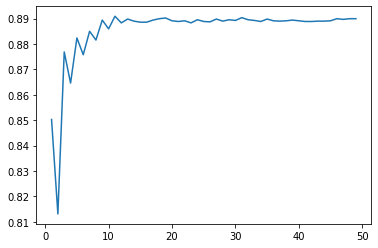

In [21]:
plt.plot(k_range, scores_list)

In [ ]:
scores_list.index(max(scores_list))

In [ ]:
# the K would be answer above +1
scores[32]

In [ ]:
# finding cross val score of most optimal K
from sklearn.model_selection import cross_val_score

cross_knn = KNeighborsClassifier(n_neighbors=32)

scores = cross_val_score(cross_knn, X_train, y_train, cv=10)


In [ ]:
scores

In [ ]:
scores.mean()